Import external libraries.

In [1]:
#install.packages("dplyr")
library("readxl")
library("pscl")
library(caret)
library(yardstick)
library(data.table)
library(MLmetrics)
library(ggplot2)
library(MASS)

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“package ‘yardstick’ was built under R version 3.6.3”For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.

Attaching package: ‘yardstick’

The following objects are masked from ‘package:caret’:

    precision, recall, sensitivity, specificity


Attaching package: ‘MLmetrics’

The following objects are masked from ‘package:caret’:

    MAE, RMSE

The following object is masked from ‘package:base’:

    Recall



Read in tile count data for BEST2 and BEST3 and manual count data for BEST3. Change paths to ```barretts-segment-length-predictor``` directory as appropriate.

In [24]:
best2_tff3_tile_data <- read_excel("~/Documents/barrets-segment-length-predictor/data/BEST2_TFF3_AND_GASTRIC_TILE_COUNTS_QC_PASSING.xlsx")
best2_prague_length_data <- read_excel("~/Documents/barrets-segment-length-predictor/data/BEST2_ENDOSCOPY_CRF_CLEANED_SHORTENED.xlsx")
best3_tff3_tile_data <- read_excel('~/Documents/barrets-segment-length-predictor/data/BEST3_TFF3_AND_GASTRIC_TILE_COUNTS_QC_PASSING.xlsx')
best3_prague_length_data <- read.csv('~/Documents/barrets-segment-length-predictor/data/BEST3_ENDOSCOPY_CRF_CLEANED.csv')
best3_manual_tff3_data <- read_excel("~/Documents/barrets-segment-length-predictor/data/BEST3_TFF3_MANUAL_COUNTS.xlsx")

Explore relationship between manual count of TFF3 positive gland groups and C and M segment lengths

In [7]:
# remove rows missing count or segment length data
best3_manual_tff3_data <- setDT(best3_manual_tff3_data)
best3_manual_tff3_data <- na.omit(best3_manual_tff3_data, 
                                  cols=c('TFF3CountSlide1', 'TFF3CountSlide2', 'PragueCLength', 'PragueMLength'))

# add columns aggregating the counts of the two slides for each patient
best3_manual_tff3_data$TFF3CountSlideSum <- best3_manual_tff3_data$TFF3CountSlide1 + best3_manual_tff3_data$TFF3CountSlide2
best3_manual_tff3_data$TFF3CountSlideAvg <- best3_manual_tff3_data$TFF3CountSlideSum / 2

# correlation metrics
print('Prague C ~ TFF3 positive manual gland count slide1 Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlide1, best3_manual_tff3_data$PragueCLength, method = c("spearman"))

print('Prague C ~ TFF3 positive manual gland count slide2 Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlide2, best3_manual_tff3_data$PragueCLength, method = c("spearman"))

print('Prague C ~ TFF3 positive manual gland count avg Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlideAvg, best3_manual_tff3_data$PragueCLength, method = c("spearman"))

print('Prague M ~ TFF3 positive manual gland count slide1 Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlide1, best3_manual_tff3_data$PragueMLength, method = c("spearman"))

print('Prague M ~ TFF3 positive manual gland count slide2 Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlide2, best3_manual_tff3_data$PragueMLength, method = c("spearman"))

print('Prague M ~ TFF3 positive manual gland count avg Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlideAvg, best3_manual_tff3_data$PragueMLength, method = c("spearman"))

[1] "Prague C ~ TFF3 positive manual gland count slide1 Spearman rho"


[1] 0.3914214

[1] "Prague C ~ TFF3 positive manual gland count slide2 Spearman rho"


[1] 0.3775943

[1] "Prague C ~ TFF3 positive manual gland count avg Spearman rho"


[1] 0.3840293

[1] "Prague M ~ TFF3 positive manual gland count slide1 Spearman rho"


[1] 0.4284946

[1] "Prague M ~ TFF3 positive manual gland count slide2 Spearman rho"


[1] 0.3950152

[1] "Prague M ~ TFF3 positive manual gland count avg Spearman rho"


[1] 0.4189175

Plot BEST3 TFF3 manual count vs segment length

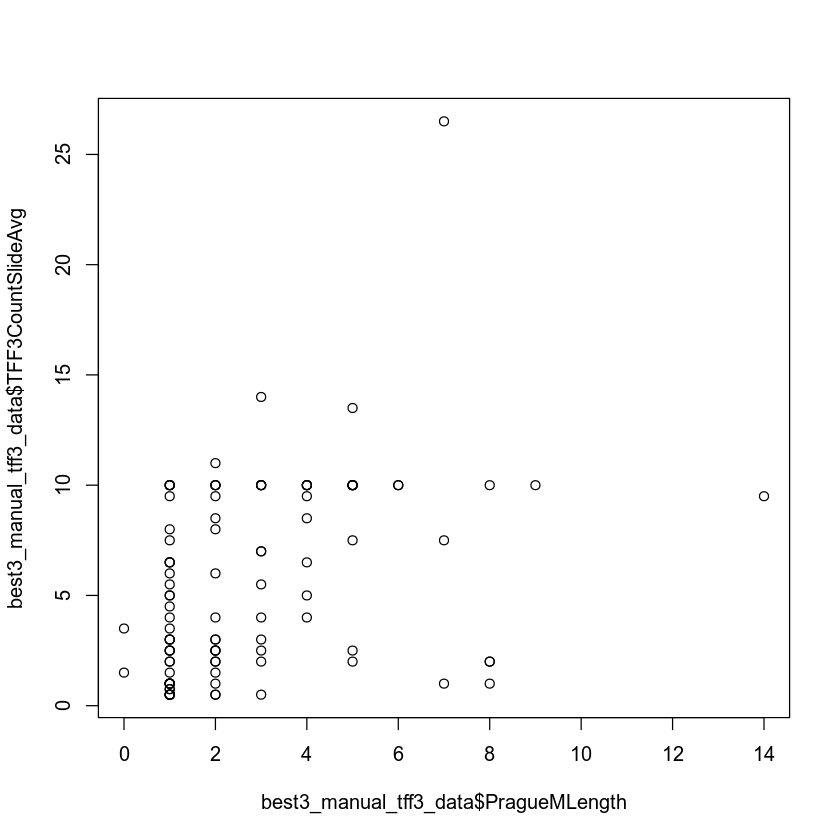

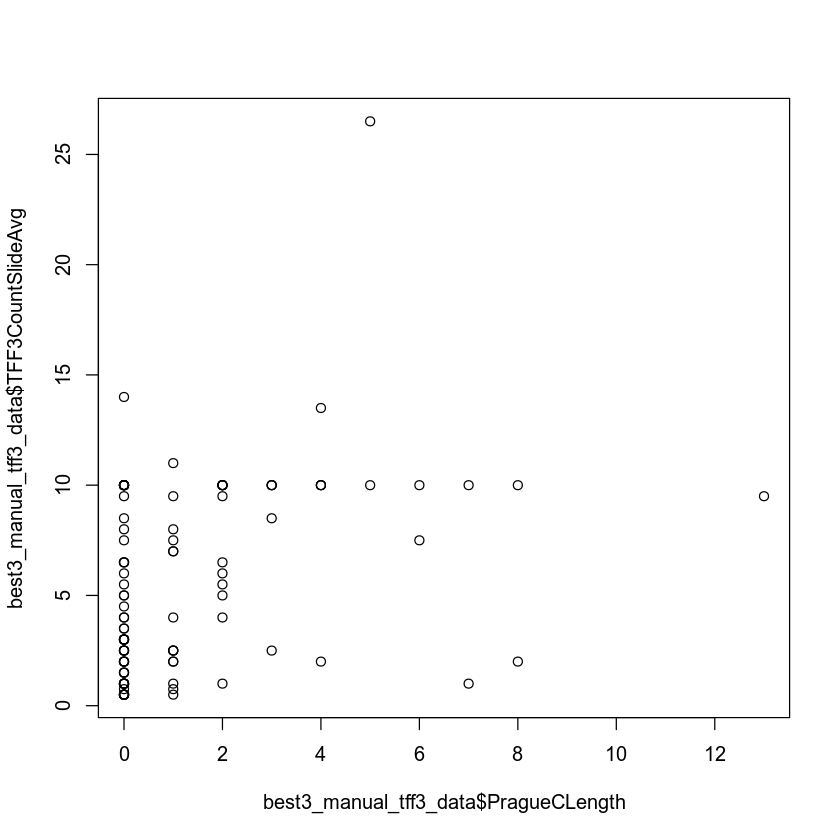

In [8]:
plot(best3_manual_tff3_data$PragueMLength, best3_manual_tff3_data$TFF3CountSlideAvg)
plot(best3_manual_tff3_data$PragueCLength, best3_manual_tff3_data$TFF3CountSlideAvg)

Merge data appropriately and add new columns for training.

In [28]:
# Merge tile count and Prague length data and perform some cleaning tasks
best2_tff3_prague_data = merge(best2_tff3_tile_data, best2_prague_length_data, by='Case')
best3_tff3_prague_data = merge(best3_tff3_tile_data, best3_prague_length_data, by='Case')
tff3_prague_data = rbind(best2_tff3_prague_data[, c('Case', 'Gastric_count', 'TFF3_positive_count', 'PRAGUE_C', 'PRAGUE_M')],
                            best3_tff3_prague_data[, c('Case', 'Gastric_count', 'TFF3_positive_count', 'PRAGUE_C', 'PRAGUE_M')])
tff3_prague_data$PRAGUE_C <- as.numeric(tff3_prague_data$PRAGUE_C)
tff3_prague_data$PRAGUE_M <- as.numeric(tff3_prague_data$PRAGUE_M)
tff3_prague_data$TFF3_positive_count <- as.numeric(tff3_prague_data$TFF3_positive_count)
tff3_prague_data$Gastric_count <- as.numeric(tff3_prague_data$Gastric_count)


# Add C≥1, C>=2, C>=3, M>=1, M≥3, M>=4, and M>=5 columns
tff3_prague_data$PRAGUE_C_gtet_1cm <- ifelse(tff3_prague_data$PRAGUE_C >= 1, 1, 0)
tff3_prague_data$PRAGUE_C_gtet_2cm <- ifelse(tff3_prague_data$PRAGUE_C >= 2, 1, 0)
tff3_prague_data$PRAGUE_C_gtet_3cm <- ifelse(tff3_prague_data$PRAGUE_C >= 3, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_1cm <- ifelse(tff3_prague_data$PRAGUE_M >= 1, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_3cm <- ifelse(tff3_prague_data$PRAGUE_M >= 3, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_4cm <- ifelse(tff3_prague_data$PRAGUE_M >= 4, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_5cm <- ifelse(tff3_prague_data$PRAGUE_M >= 5, 1, 0)

# Add C>=1 OR M>=1 column, a C≥1 OR M≥3 column, a C≥2 OR M≥4 colum, and a C≥3 OR M≥5 column
tff3_prague_data$C_gtet_1_or_M_gtet_1 <- ifelse(tff3_prague_data$PRAGUE_C >= 1 | tff3_prague_data$PRAGUE_M >= 1, 1, 0)
tff3_prague_data$C_gtet_1_or_M_gtet_3 <- ifelse(tff3_prague_data$PRAGUE_C >= 1 | tff3_prague_data$PRAGUE_M >= 3, 1, 0)
tff3_prague_data$C_gtet_2_or_M_gtet_4 <- ifelse(tff3_prague_data$PRAGUE_C >= 2 | tff3_prague_data$PRAGUE_M >= 4, 1, 0)
tff3_prague_data$C_gtet_3_or_M_gtet_5 <- ifelse(tff3_prague_data$PRAGUE_C >= 3 | tff3_prague_data$PRAGUE_M >= 5, 1, 0)



# Create doubled C and M columns to have only integer values for Poisson regression models
tff3_prague_data$PRAGUE_M_doubled <- tff3_prague_data$PRAGUE_M * 2
tff3_prague_data$PRAGUE_C_doubled <- tff3_prague_data$PRAGUE_C * 2

# Re-split data into BEST2 and BEST3 pieces
best2_tff3_prague_data <- head(tff3_prague_data, nrow(best2_tff3_prague_data))
best3_tff3_prague_data <- tail(tff3_prague_data, nrow(best3_tff3_prague_data))

# Convert to data.table
best2_tff3_prague_data <- setDT(best2_tff3_prague_data)
best3_tff3_prague_data <- setDT(best3_tff3_prague_data)
tff3_prague_data <- setDT(tff3_prague_data)


# Create versions of the above data tables with no patients with no patients with TFF3 positive tile counts of 0
best2_tff3_prague_data_nozeros <- best2_tff3_prague_data[best2_tff3_prague_data$TFF3_positive_count != 0,]
best3_tff3_prague_data_nozeros <- best3_tff3_prague_data[best3_tff3_prague_data$TFF3_positive_count != 0,]
tff3_prague_data_nozeros <- tff3_prague_data[tff3_prague_data$TFF3_positive_count != 0,]

Show how many patients have long segments by diagnostic criteria in BEST2 and BEST3.

In [29]:
print(paste0("BEST2 long segment patients: ", sum(best2_tff3_prague_data$C_gtet_1_or_M_gtet_3)))
print(paste0("BEST3 long segment patients: ", sum(best3_tff3_prague_data$C_gtet_1_or_M_gtet_3)))
print(paste0("Total BEST2 patients: ", nrow(best2_tff3_prague_data)))
print(paste0("Total BEST3 patients: ", nrow(best3_tff3_prague_data)))

[1] "BEST2 long segment patients: 315"
[1] "BEST3 long segment patients: 47"
[1] "Total BEST2 patients: 529"
[1] "Total BEST3 patients: 158"


Compute Spearman's correlation coefficients.

In [11]:
# correlation metrics
print('Prague C ~ TFF3 positive tile count Spearman rho')
cor(best2_tff3_prague_data$TFF3_positive_count, best2_tff3_prague_data$PRAGUE_C, method = c("spearman"))
print('Prague M ~ TFF3 positive tile count Spearman rho')
cor(best2_tff3_prague_data$TFF3_positive_count, best2_tff3_prague_data$PRAGUE_M, method = c("spearman"))
print('Prague C ~ Gastric tile count Spearman rho')
cor(best2_tff3_prague_data$Gastric_count, best2_tff3_prague_data$PRAGUE_C, method = c("spearman"))
print('Prague M ~ Gastric tile count Spearman rho')
cor(best2_tff3_prague_data$Gastric_count, best2_tff3_prague_data$PRAGUE_M, method = c("spearman"))

[1] "Prague C ~ TFF3 positive tile count Spearman rho"


[1] 0.7317658

[1] "Prague M ~ TFF3 positive tile count Spearman rho"


[1] 0.7728281

[1] "Prague C ~ Gastric tile count Spearman rho"


[1] -0.02362228

[1] "Prague M ~ Gastric tile count Spearman rho"


[1] -0.04628601

CLASSIFICATION SECTION

Train 5-fold cross validation logistic regression models for predicting segment length class: (C≥1 OR M≥3) vs. (C<1 AND M<3)

In [30]:
# create 5 folds for cross validation across 691 patients from BEST2 and BEST3 
# (138 patients per val fold, 553 per training fold)
set.seed(366)

# For BEST2 only analyses
tff3_prague_data_shuffled <- best2_tff3_prague_data[sample(nrow(best2_tff3_prague_data)),]

# split folds into training and validation components
fold_size = round(nrow(tff3_prague_data_shuffled)/5)
n <- nrow(tff3_prague_data_shuffled)
r  <- rep(1:ceiling(n/fold_size), each=fold_size)[1:n]
d <- split(tff3_prague_data_shuffled, r)
val1 <- d[["1"]]
val2 <- d[["2"]]
val3 <- d[["3"]]
val4 <- d[["4"]]
val5 <- d[["5"]]
train1 <- rbind(val2, val3, val4, val5)
train2 <- rbind(val1, val3, val4, val5)
train3 <- rbind(val1, val2, val4, val5)
train4 <- rbind(val1, val2, val3, val5)
train5 <- rbind(val1, val2, val3, val4)

# 5-fold classification models trained on training components (C>=1 or M>=3)
logreg_c_gtet_1cm_or_m_gtet_1cm_1 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_1cm_or_m_gtet_1cm_2 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_1cm_or_m_gtet_1cm_3 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_1cm_or_m_gtet_1cm_4 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_1cm_or_m_gtet_1cm_5 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=1 or M>=3)
logreg_c_gtet_1cm_or_m_gtet_3cm_1 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_1cm_or_m_gtet_3cm_2 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_1cm_or_m_gtet_3cm_3 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_1cm_or_m_gtet_3cm_4 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_1cm_or_m_gtet_3cm_5 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=2 or M>=4)
logreg_c_gtet_2cm_or_m_gtet_4cm_1 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_2cm_or_m_gtet_4cm_2 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_2cm_or_m_gtet_4cm_3 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_2cm_or_m_gtet_4cm_4 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_2cm_or_m_gtet_4cm_5 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=3 or M>=5)
logreg_c_gtet_3cm_or_m_gtet_5cm_1 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_3cm_or_m_gtet_5cm_2 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_3cm_or_m_gtet_5cm_3 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_3cm_or_m_gtet_5cm_4 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_3cm_or_m_gtet_5cm_5 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=1)
logreg_c_gtet_1cm_1 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_1cm_2 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_1cm_3 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_1cm_4 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_1cm_5 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=2)
logreg_c_gtet_2cm_1 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_2cm_2 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_2cm_3 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_2cm_4 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_2cm_5 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=3)
logreg_c_gtet_3cm_1 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_3cm_2 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_3cm_3 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_3cm_4 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_3cm_5 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (M>=1)
logreg_m_gtet_1cm_1 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_m_gtet_1cm_2 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_m_gtet_1cm_3 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_m_gtet_1cm_4 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_m_gtet_1cm_5 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (M>=3)
logreg_m_gtet_3cm_1 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_m_gtet_3cm_2 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_m_gtet_3cm_3 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_m_gtet_3cm_4 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_m_gtet_3cm_5 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (M>=4)
logreg_m_gtet_4cm_1 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_m_gtet_4cm_2 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_m_gtet_4cm_3 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_m_gtet_4cm_4 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_m_gtet_4cm_5 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (M>=5)
logreg_m_gtet_5cm_1 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_m_gtet_5cm_2 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_m_gtet_5cm_3 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_m_gtet_5cm_4 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_m_gtet_5cm_5 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train5)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

We can now evalute model performance on validation component of each fold. Let's first define performance metric functions.

In [31]:
RSQUARE = function(y_actual,y_predict){
  cor(y_actual,y_predict)^2
}
RMSE = function(y_actual, y_predict){
    sqrt(mean((y_predict - y_actual)^2))
}
METRIFY = function(y_actual, y_predict, model){
    acc = Accuracy(ifelse(y_predict >= 0.5, 1, 0), y_actual)
    acc_balanced = bal_accuracy_vec(factor(y_actual), factor(ifelse(y_predict >= 0.5, 1, 0)))
    prec_long = Precision(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    prec_short = Precision(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=0)
    rec_long = Recall(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    rec_short = Recall(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=0)
    f1_long = F1_Score(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    f1_short = F1_Score(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=0)
    tile_cutoff = unname(dose.p(model, p=0.5)[1])
    tile_cutoff_se = unname(attr(dose.p(model, p=0.5), "SE"))
    
    list(Accuracy=acc, Balanced_acc=acc_balanced, Precision_long=prec_long, Precision_short=prec_short, 
         Recall_long=rec_long, Recall_short=rec_short, F1_long=f1_long, F1_short=f1_short, 
         Tile_cutoff=tile_cutoff, Tile_cutoff_SE=tile_cutoff_se)
}

Get classification predictions for each fold on validation components

In [32]:
# C>=1 or M>=1
logreg_c_gtet_1cm_or_m_gtet_1cm_1_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_1cm_2_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_1cm_3_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_1cm_4_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_1cm_5_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=1 or M>=3
logreg_c_gtet_1cm_or_m_gtet_3cm_1_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_2_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_3_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_4_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_5_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=2 or M>=4
logreg_c_gtet_2cm_or_m_gtet_4cm_1_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_or_m_gtet_4cm_2_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_or_m_gtet_4cm_3_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_or_m_gtet_4cm_4_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_or_m_gtet_4cm_5_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=3 or M>=5
logreg_c_gtet_3cm_or_m_gtet_5cm_1_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_or_m_gtet_5cm_2_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_or_m_gtet_5cm_3_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_or_m_gtet_5cm_4_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_or_m_gtet_5cm_5_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=1
logreg_c_gtet_1cm_1_pred <- predict(logreg_c_gtet_1cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_2_pred <- predict(logreg_c_gtet_1cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_3_pred <- predict(logreg_c_gtet_1cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_4_pred <- predict(logreg_c_gtet_1cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_5_pred <- predict(logreg_c_gtet_1cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=2
logreg_c_gtet_2cm_1_pred <- predict(logreg_c_gtet_2cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_2_pred <- predict(logreg_c_gtet_2cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_3_pred <- predict(logreg_c_gtet_2cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_4_pred <- predict(logreg_c_gtet_2cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_5_pred <- predict(logreg_c_gtet_2cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=3
logreg_c_gtet_3cm_1_pred <- predict(logreg_c_gtet_3cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_2_pred <- predict(logreg_c_gtet_3cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_3_pred <- predict(logreg_c_gtet_3cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_4_pred <- predict(logreg_c_gtet_3cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_5_pred <- predict(logreg_c_gtet_3cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# M>=1
logreg_m_gtet_1cm_1_pred <- predict(logreg_m_gtet_1cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_m_gtet_1cm_2_pred <- predict(logreg_m_gtet_1cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_m_gtet_1cm_3_pred <- predict(logreg_m_gtet_1cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_m_gtet_1cm_4_pred <- predict(logreg_m_gtet_1cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_m_gtet_1cm_5_pred <- predict(logreg_m_gtet_1cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# M>=3
logreg_m_gtet_3cm_1_pred <- predict(logreg_m_gtet_3cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_m_gtet_3cm_2_pred <- predict(logreg_m_gtet_3cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_m_gtet_3cm_3_pred <- predict(logreg_m_gtet_3cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_m_gtet_3cm_4_pred <- predict(logreg_m_gtet_3cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_m_gtet_3cm_5_pred <- predict(logreg_m_gtet_3cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# M>=4
logreg_m_gtet_4cm_1_pred <- predict(logreg_m_gtet_4cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_m_gtet_4cm_2_pred <- predict(logreg_m_gtet_4cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_m_gtet_4cm_3_pred <- predict(logreg_m_gtet_4cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_m_gtet_4cm_4_pred <- predict(logreg_m_gtet_4cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_m_gtet_4cm_5_pred <- predict(logreg_m_gtet_4cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# M>=5
logreg_m_gtet_5cm_1_pred <- predict(logreg_m_gtet_5cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_m_gtet_5cm_2_pred <- predict(logreg_m_gtet_5cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_m_gtet_5cm_3_pred <- predict(logreg_m_gtet_5cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_m_gtet_5cm_4_pred <- predict(logreg_m_gtet_5cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_m_gtet_5cm_5_pred <- predict(logreg_m_gtet_5cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

Get performance metric results

In [33]:
# C>=1 or M>=1
fold1_c1m1 = METRIFY(val1$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_1_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_1)
fold2_c1m1 = METRIFY(val2$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_2_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_2)
fold3_c1m1 = METRIFY(val3$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_3_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_3)
fold4_c1m1 = METRIFY(val4$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_4_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_4)
fold5_c1m1 = METRIFY(val5$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_5_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_5)

# C>=1 or M>=3
fold1_c1m3 = METRIFY(val1$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_1_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_1)
fold2_c1m3 = METRIFY(val2$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_2_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_2)
fold3_c1m3 = METRIFY(val3$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_3_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_3)
fold4_c1m3 = METRIFY(val4$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_4_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_4)
fold5_c1m3 = METRIFY(val5$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_5_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_5)

# C>=2 or M>=4
fold1_c2m4 = METRIFY(val1$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_1_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_1)
fold2_c2m4 = METRIFY(val2$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_2_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_2)
fold3_c2m4 = METRIFY(val3$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_3_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_3)
fold4_c2m4 = METRIFY(val4$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_4_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_4)
fold5_c2m4 = METRIFY(val5$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_5_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_5)

# C>=3 or M>=5
fold1_c3m5 = METRIFY(val1$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_1_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_1)
fold2_c3m5 = METRIFY(val2$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_2_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_2)
fold3_c3m5 = METRIFY(val3$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_3_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_3)
fold4_c3m5 = METRIFY(val4$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_4_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_4)
fold5_c3m5 = METRIFY(val5$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_5_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_5)

# C>=1
fold1_c1 = METRIFY(val1$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_1_pred, logreg_c_gtet_1cm_1)
fold2_c1 = METRIFY(val2$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_2_pred, logreg_c_gtet_1cm_2)
fold3_c1 = METRIFY(val3$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_3_pred, logreg_c_gtet_1cm_3)
fold4_c1 = METRIFY(val4$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_4_pred, logreg_c_gtet_1cm_4)
fold5_c1 = METRIFY(val5$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_5_pred, logreg_c_gtet_1cm_5)

# C>=2
fold1_c2 = METRIFY(val1$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_1_pred, logreg_c_gtet_2cm_1)
fold2_c2 = METRIFY(val2$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_2_pred, logreg_c_gtet_2cm_2)
fold3_c2 = METRIFY(val3$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_3_pred, logreg_c_gtet_2cm_3)
fold4_c2 = METRIFY(val4$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_4_pred, logreg_c_gtet_2cm_4)
fold5_c2 = METRIFY(val5$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_5_pred, logreg_c_gtet_2cm_5)

# C>=3
fold1_c3 = METRIFY(val1$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_1_pred, logreg_c_gtet_3cm_1)
fold2_c3 = METRIFY(val2$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_2_pred, logreg_c_gtet_3cm_2)
fold3_c3 = METRIFY(val3$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_3_pred, logreg_c_gtet_3cm_3)
fold4_c3 = METRIFY(val4$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_4_pred, logreg_c_gtet_3cm_4)
fold5_c3 = METRIFY(val5$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_5_pred, logreg_c_gtet_3cm_5)

# M>=1
fold1_m1 = METRIFY(val1$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_1_pred, logreg_m_gtet_1cm_1)
fold2_m1 = METRIFY(val2$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_2_pred, logreg_m_gtet_1cm_2)
fold3_m1 = METRIFY(val3$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_3_pred, logreg_m_gtet_1cm_3)
fold4_m1 = METRIFY(val4$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_4_pred, logreg_m_gtet_1cm_4)
fold5_m1 = METRIFY(val5$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_5_pred, logreg_m_gtet_1cm_5)

# M>=3
fold1_m3 = METRIFY(val1$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_1_pred, logreg_m_gtet_3cm_1)
fold2_m3 = METRIFY(val2$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_2_pred, logreg_m_gtet_3cm_2)
fold3_m3 = METRIFY(val3$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_3_pred, logreg_m_gtet_3cm_3)
fold4_m3 = METRIFY(val4$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_4_pred, logreg_m_gtet_3cm_4)
fold5_m3 = METRIFY(val5$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_5_pred, logreg_m_gtet_3cm_5)

# M>=4
fold1_m4 = METRIFY(val1$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_1_pred, logreg_m_gtet_4cm_1)
fold2_m4 = METRIFY(val2$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_2_pred, logreg_m_gtet_4cm_2)
fold3_m4 = METRIFY(val3$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_3_pred, logreg_m_gtet_4cm_3)
fold4_m4 = METRIFY(val4$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_4_pred, logreg_m_gtet_4cm_4)
fold5_m4 = METRIFY(val5$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_5_pred, logreg_m_gtet_4cm_5)

# M>=5
fold1_m5 = METRIFY(val1$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_1_pred, logreg_m_gtet_5cm_1)
fold2_m5 = METRIFY(val2$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_2_pred, logreg_m_gtet_5cm_2)
fold3_m5 = METRIFY(val3$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_3_pred, logreg_m_gtet_5cm_3)
fold4_m5 = METRIFY(val4$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_4_pred, logreg_m_gtet_5cm_4)
fold5_m5 = METRIFY(val5$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_5_pred, logreg_m_gtet_5cm_5)

Print results

In [34]:
# C>=1 or M>=1 
results = rbindlist(list(fold1_c1m1, fold2_c1m1, fold3_c1m1, fold4_c1m1, fold5_c1m1))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=1cm or M>=1cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=1cm or M>=1cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.7924528,0.8143896,0.9245283,0.6603774,0.7313433,0.8974359,0.8166667,0.7608696,6.123937,2.402157
Fold2,0.8773585,0.8786657,0.9152542,0.8297872,0.8709677,0.8863636,0.8925620,0.8571429,4.632022,0.746372
Fold3,0.8113208,0.8559966,0.9821429,0.6200000,0.7432432,0.9687500,0.8461538,0.7560976,7.806023,2.398120
Fold4,0.7924528,0.8475275,0.9827586,0.5625000,0.7307692,0.9642857,0.8382353,0.7105263,7.499915,2.213443
Fold5,0.8571429,0.8517873,0.9275362,0.7222222,0.8648649,0.8387097,0.8951049,0.7761194,6.275538,2.325775


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.8261456       0.8496733       0.9464440       0.6789774       0.7882377 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9111090       0.8577445       0.7721511       6.4674871       2.0171733

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.03896720      0.02310063      0.03318043      0.10247561      0.07293847 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.05520688      0.03467851      0.05343676      1.26307047      0.71449727

In [35]:
# C>=1 or M>=3 
results = rbindlist(list(fold1_c1m3, fold2_c1m3, fold3_c1m3, fold4_c1m3, fold5_c1m3))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=1cm or M>=3cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=1cm or M>=3cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.8018868,0.8224638,0.9756098,0.6923077,0.6666667,0.9782609,0.7920792,0.8108108,17.80157,3.489401
Fold2,0.8584906,0.8641246,0.9375000,0.7931034,0.7894737,0.9387755,0.8571429,0.8598131,13.33450,2.040552
Fold3,0.7641509,0.8106061,1.0000000,0.6153846,0.6212121,1.0000000,0.7663551,0.7619048,20.13999,3.658029
Fold4,0.7830189,0.8015691,0.9074074,0.6538462,0.7313433,0.8717949,0.8099174,0.7472527,15.98679,2.629123
Fold5,0.8666667,0.8778846,0.9473684,0.7708333,0.8307692,0.9250000,0.8852459,0.8409091,16.42950,3.132873


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.8148428       0.8353296       0.9535771       0.7050950       0.7278930 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9427663       0.8221481       0.8041381      16.7384700       2.9899954

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.04566488      0.03375143      0.03559910      0.07567187      0.08590267 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.04975960      0.04840596      0.04877482      2.49739729      0.66101463

In [36]:
# C>=2 or M>=4 
results = rbindlist(list(fold1_c2m4, fold2_c2m4, fold3_c2m4, fold4_c2m4, fold5_c2m4))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=2cm or M>=4cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=2cm or M>=4cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.7641509,0.7388335,0.7647059,0.7638889,0.6046512,0.8730159,0.6753247,0.8148148,39.68862,5.338240
Fold2,0.7547170,0.7399425,0.8235294,0.7222222,0.5833333,0.8965517,0.6829268,0.8000000,38.08739,4.821616
Fold3,0.7358491,0.7440285,0.9354839,0.6533333,0.5272727,0.9607843,0.6744186,0.7777778,50.67257,6.590058
Fold4,0.8490566,0.8472222,0.9285714,0.7968750,0.7500000,0.9444444,0.8297872,0.8644068,43.57168,6.183573
Fold5,0.7428571,0.7723547,0.9473684,0.6268657,0.5901639,0.9545455,0.7272727,0.7567568,50.75117,6.938955


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.7693261       0.7684763       0.8799318       0.7126370       0.6110842 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9258684       0.7179460       0.8027512      44.5542860       5.9744884

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.04587614      0.04611542      0.08132925      0.07191717      0.08302276 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.03885686      0.06620612      0.04090743      5.96438846      0.87845966

In [37]:
# C>=3 or M>=5 
results = rbindlist(list(fold1_c3m5, fold2_c3m5, fold3_c3m5, fold4_c3m5, fold5_c3m5))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=3cm or M>=5cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=3cm or M>=5cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.8207547,0.7287256,0.8888889,0.8068182,0.4848485,0.9726027,0.6274510,0.8819876,134.12951,18.68902
Fold2,0.8396226,0.7810458,0.8400000,0.8395062,0.6176471,0.9444444,0.7118644,0.8888889,91.91892,10.80557
Fold3,0.6415094,0.6059626,0.9166667,0.6063830,0.2291667,0.9827586,0.3666667,0.7500000,159.50922,20.19925
Fold4,0.8018868,0.7522727,0.8800000,0.7777778,0.5500000,0.9545455,0.6769231,0.8571429,132.37814,18.54789
Fold5,0.7238095,0.6995598,0.8461538,0.6835443,0.4680851,0.9310345,0.6027397,0.7883212,141.61527,19.09947


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.7655166       0.7135133       0.8743419       0.7428059       0.4699495 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9570771       0.5971290       0.8332681     131.9102128      17.4682407

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.08213252      0.06718665      0.03165812      0.09590972      0.14699020 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.02088538      0.13564208      0.06121901     24.80091372      3.78042454

In [38]:
# C>=1
results = rbindlist(list(fold1_c1, fold2_c1, fold3_c1, fold4_c1, fold5_c1))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=1cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=1cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.7735849,0.7931034,1.0000000,0.6666667,0.5862069,1.0000000,0.7391304,0.8000000,41.26668,6.640244
Fold2,0.7735849,0.7653571,0.8611111,0.7285714,0.6200000,0.9107143,0.7209302,0.8095238,30.38223,4.877522
Fold3,0.7264151,0.7300570,0.8787879,0.6575342,0.5370370,0.9230769,0.6666667,0.7680000,35.06632,5.492585
Fold4,0.7830189,0.7942661,0.8913043,0.7000000,0.6949153,0.8936170,0.7809524,0.7850467,34.05945,5.523742
Fold5,0.7904762,0.8111111,0.9523810,0.6825397,0.6666667,0.9555556,0.7843137,0.7962963,36.34240,6.100627


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.7694160       0.7787790       0.9167169       0.6870624       0.6209652 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9365928       0.7383987       0.7917734      35.4234126       5.7269440

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.02506196      0.03179775      0.05784551      0.02827867      0.06286939 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.04206945      0.04839983      0.01591880      3.94935870      0.66923253

In [39]:
# C>=2
results = rbindlist(list(fold1_c2, fold2_c2, fold3_c2, fold4_c2, fold5_c2))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=2cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=2cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.7735849,0.7030233,0.8947368,0.7471264,0.4358974,0.9701493,0.5862069,0.8441558,99.67602,14.629629
Fold2,0.7735849,0.7306502,0.7333333,0.7894737,0.5789474,0.8823529,0.6470588,0.8333333,63.38298,7.607368
Fold3,0.6415094,0.6165414,0.8235294,0.6067416,0.2857143,0.9473684,0.4242424,0.7397260,111.51165,14.863609
Fold4,0.8113208,0.7902174,0.9062500,0.7702703,0.6304348,0.9500000,0.7435897,0.8507463,103.20940,15.496086
Fold5,0.7428571,0.7447388,0.9062500,0.6712329,0.5471698,0.9423077,0.6823529,0.7840000,117.60011,17.325635


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.7485714       0.7170342       0.8528199       0.7169690       0.4956327 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9384357       0.6166902       0.8103923      99.0760339      13.9844657

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.06458280      0.06442793      0.07516907      0.07623861      0.13729808 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.03308906      0.12176075      0.04739458     21.14961285      3.71836366

In [40]:
# C>=3
results = rbindlist(list(fold1_c3, fold2_c3, fold3_c3, fold4_c3, fold5_c3))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=3cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=3cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.8396226,0.7352688,0.9375000,0.8222222,0.4838710,0.9866667,0.6382979,0.8969697,215.4402,30.03522
Fold2,0.8301887,0.7326467,0.7894737,0.8390805,0.5172414,0.9480519,0.6250000,0.8902439,159.9537,20.79854
Fold3,0.6603774,0.5654784,0.8571429,0.6464646,0.1463415,0.9846154,0.2500000,0.7804878,229.2683,29.41158
Fold4,0.7830189,0.7075397,0.8095238,0.7764706,0.4722222,0.9428571,0.5964912,0.8516129,172.3057,22.50250
Fold5,0.7333333,0.6567599,0.8235294,0.7159091,0.3589744,0.9545455,0.5000000,0.8181818,210.7667,29.36552


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.7693082       0.6795387       0.8434340       0.7600294       0.3957301 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9633473       0.5219578       0.8474992     197.5469405      26.4226706

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.07415972      0.07113188      0.05808217      0.07942116      0.15160023 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.02078095      0.16136227      0.04909531     29.79744061      4.40576664

In [41]:
# M>=1
results = rbindlist(list(fold1_m1, fold2_m1, fold3_m1, fold4_m1, fold5_m1))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression M>=1cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression M>=1cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.7924528,0.8143896,0.9245283,0.6603774,0.7313433,0.8974359,0.8166667,0.7608696,6.123937,2.402157
Fold2,0.8773585,0.8786657,0.9152542,0.8297872,0.8709677,0.8863636,0.8925620,0.8571429,4.632022,0.746372
Fold3,0.8113208,0.8559966,0.9821429,0.6200000,0.7432432,0.9687500,0.8461538,0.7560976,7.806023,2.398120
Fold4,0.7924528,0.8475275,0.9827586,0.5625000,0.7307692,0.9642857,0.8382353,0.7105263,7.499915,2.213443
Fold5,0.8571429,0.8517873,0.9275362,0.7222222,0.8648649,0.8387097,0.8951049,0.7761194,6.275538,2.325775


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.8261456       0.8496733       0.9464440       0.6789774       0.7882377 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9111090       0.8577445       0.7721511       6.4674871       2.0171733

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.03896720      0.02310063      0.03318043      0.10247561      0.07293847 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.05520688      0.03467851      0.05343676      1.26307047      0.71449727

In [42]:
# M>=3
results = rbindlist(list(fold1_m3, fold2_m3, fold3_m3, fold4_m3, fold5_m3))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression M>=3cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression M>=3cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.8113208,0.8091168,0.9000000,0.7575758,0.6923077,0.9259259,0.7826087,0.8333333,25.35430,3.939992
Fold2,0.8207547,0.8226496,0.9069767,0.7619048,0.7222222,0.9230769,0.8041237,0.8347826,22.79752,3.199179
Fold3,0.7264151,0.7628299,0.9714286,0.6056338,0.5483871,0.9772727,0.7010309,0.7478261,32.01544,4.806832
Fold4,0.7641509,0.7729895,0.8541667,0.6896552,0.6949153,0.8510638,0.7663551,0.7619048,23.76343,3.547918
Fold5,0.8380952,0.8611111,0.9791667,0.7192982,0.7460317,0.9761905,0.8468468,0.8282828,28.14866,4.411702


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.7921473       0.8057394       0.9223477       0.7068135       0.6807728 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9307060       0.7801931       0.8012259      26.4158706       3.9811245

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.04583050      0.03961428      0.05249206      0.06383467      0.07719427 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.05162660      0.05357091      0.04268111      3.72869232      0.64575310

In [43]:
# M>=4
results = rbindlist(list(fold1_m4, fold2_m4, fold3_m4, fold4_m4, fold5_m4))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression M>=4cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression M>=4cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.8018868,0.7473485,0.9130435,0.7710843,0.5250000,0.9696970,0.6666667,0.8590604,60.29165,7.463463
Fold2,0.7830189,0.7518939,0.7575758,0.7945205,0.6250000,0.8787879,0.6849315,0.8345324,49.65496,5.847664
Fold3,0.6698113,0.6638177,0.9473684,0.6091954,0.3461538,0.9814815,0.5070423,0.7517730,74.03452,8.838432
Fold4,0.8301887,0.8170290,0.8684211,0.8088235,0.7173913,0.9166667,0.7857143,0.8593750,61.61561,8.053148
Fold5,0.7714286,0.7878289,0.9714286,0.6714286,0.5964912,0.9791667,0.7391304,0.7966102,74.58965,9.625424


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.7712668       0.7535836       0.8915675       0.7310105       0.5620073 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9451599       0.6766970       0.8202702      64.0372782       7.9656263

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.06091125      0.05765786      0.08432422      0.08672259      0.13898171 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.04553816      0.10575189      0.04606770     10.46473556      1.43721182

In [44]:
# M>=5
results = rbindlist(list(fold1_m5, fold2_m5, fold3_m5, fold4_m5, fold5_m5))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression M>=5cm performance on validation folds:')
results
print("Means:")
colMeans(results)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression M>=5cm performance on validation folds:"


,Accuracy,Balanced_acc,Precision_long,Precision_short,Recall_long,Recall_short,F1_long,F1_short,Tile_cutoff,Tile_cutoff_SE
Fold1,0.8490566,0.7535088,0.8888889,0.8409091,0.5333333,0.9736842,0.6666667,0.9024390,166.7215,22.24327
Fold2,0.8301887,0.7586996,0.7083333,0.8658537,0.6071429,0.9102564,0.6538462,0.8875000,105.8656,11.89924
Fold3,0.6603774,0.6029144,0.9090909,0.6315789,0.2222222,0.9836066,0.3571429,0.7692308,191.6891,23.24246
Fold4,0.8113208,0.7484520,0.9090909,0.7857143,0.5263158,0.9705882,0.6666667,0.8684211,165.6450,22.39686
Fold5,0.7333333,0.6851088,0.8571429,0.7023810,0.4186047,0.9516129,0.5625000,0.8082192,168.8066,21.81099


[1] "Means:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
      0.7768553       0.7097367       0.8545094       0.7652874       0.4615238 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
      0.9579497       0.5813645       0.8471620     159.7455713      20.3185641

[1] "Standard deviations:"


Accuracy    Balanced_acc  Precision_long Precision_short     Recall_long 
     0.07859169      0.06676410      0.08443135      0.09757643      0.14972209 
   Recall_short         F1_long        F1_short     Tile_cutoff  Tile_cutoff_SE 
     0.02907055      0.13270053      0.05640140     31.97265398      4.73511745

Train a model on all BEST2 data and infer it on BEST3 data.

In [45]:
# C>=1 or M>=1cm

print('Logistic regression C>=1 or M>=1cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_1cm_or_m_gtet_1cm_best2 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_1cm_or_m_gtet_1cm_pred_best3 <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_pred_best3, logreg_c_gtet_1cm_or_m_gtet_1cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_1cm_or_m_gtet_1cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$C_gtet_1_or_M_gtet_1))

[1] "Logistic regression C>=1 or M>=1cm performance on BEST3 test set:"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

1.785894


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 29 20
         1 39 70
                                          
               Accuracy : 0.6266          
                 95% CI : (0.5462, 0.7021)
    No Information Rate : 0.5696          
    P-Value [Acc > NIR] : 0.08539         
                                          
                  Kappa : 0.2115          
                                          
 Mcnemar's Test P-Value : 0.01911         
                                          
            Sensitivity : 0.4265          
            Specificity : 0.7778          
         Pos Pred Value : 0.5918          
         Neg Pred Value : 0.6422          
             Prevalence : 0.4304          
         Detection Rate : 0.1835          
   Detection Prevalence : 0.3101          
      Balanced Accuracy : 0.6021          
                                          
       'Positive' Class : 0               
                                    

In [46]:
# C>=1 or M>=3cm

print('Logistic regression C>=1 or M>=3cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_1cm_or_m_gtet_3cm_best2 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_1cm_or_m_gtet_3cm_pred_best3 <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_pred_best3, logreg_c_gtet_1cm_or_m_gtet_3cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_1cm_or_m_gtet_3cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$C_gtet_1_or_M_gtet_3))

[1] "Logistic regression C>=1 or M>=3cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

2.658796


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 79  8
         1 32 39
                                          
               Accuracy : 0.7468          
                 95% CI : (0.6716, 0.8126)
    No Information Rate : 0.7025          
    P-Value [Acc > NIR] : 0.1281916       
                                          
                  Kappa : 0.472           
                                          
 Mcnemar's Test P-Value : 0.0002762       
                                          
            Sensitivity : 0.7117          
            Specificity : 0.8298          
         Pos Pred Value : 0.9080          
         Neg Pred Value : 0.5493          
             Prevalence : 0.7025          
         Detection Rate : 0.5000          
   Detection Prevalence : 0.5506          
      Balanced Accuracy : 0.7707          
                                          
       'Positive' Class : 0               
                                    

In [47]:
# C>=2 or M>=4cm

print('Logistic regression C>=2cm or M>=4cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_2cm_or_m_gtet_4cm_best2 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_2cm_or_m_gtet_4cm_pred_best3 <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_pred_best3, logreg_c_gtet_2cm_or_m_gtet_4cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_2cm_or_m_gtet_4cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$C_gtet_2_or_M_gtet_4))

[1] "Logistic regression C>=2cm or M>=4cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

5.305232


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 114  15
         1  11  18
                                          
               Accuracy : 0.8354          
                 95% CI : (0.7683, 0.8896)
    No Information Rate : 0.7911          
    P-Value [Acc > NIR] : 0.09925         
                                          
                  Kappa : 0.4788          
                                          
 Mcnemar's Test P-Value : 0.55630         
                                          
            Sensitivity : 0.9120          
            Specificity : 0.5455          
         Pos Pred Value : 0.8837          
         Neg Pred Value : 0.6207          
             Prevalence : 0.7911          
         Detection Rate : 0.7215          
   Detection Prevalence : 0.8165          
      Balanced Accuracy : 0.7287          
                                          
       'Positive' Class : 0               
                              

In [48]:
# C>=3 or M>=5cm

print('Logistic regression C>=3 or M>=5cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_3cm_or_m_gtet_5cm_best2 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_3cm_or_m_gtet_5cm_pred_best3 <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_pred_best3, logreg_c_gtet_3cm_or_m_gtet_5cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_3cm_or_m_gtet_5cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$C_gtet_3_or_M_gtet_5))

[1] "Logistic regression C>=3 or M>=5cm performance on BEST3 test set:"


15.61124


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 130  16
         1   5   7
                                         
               Accuracy : 0.8671         
                 95% CI : (0.804, 0.9158)
    No Information Rate : 0.8544         
    P-Value [Acc > NIR] : 0.3767         
                                         
                  Kappa : 0.3335         
                                         
 Mcnemar's Test P-Value : 0.0291         
                                         
            Sensitivity : 0.9630         
            Specificity : 0.3043         
         Pos Pred Value : 0.8904         
         Neg Pred Value : 0.5833         
             Prevalence : 0.8544         
         Detection Rate : 0.8228         
   Detection Prevalence : 0.9241         
      Balanced Accuracy : 0.6337         
                                         
       'Positive' Class : 0              
                                         

In [49]:
# C>=1cm

print('Logistic regression C>=1cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_1cm_best2 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_1cm_pred_best3 <- predict(logreg_c_gtet_1cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_pred_best3, logreg_c_gtet_1cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_1cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_C_gtet_1cm))

[1] "Logistic regression C>=1cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

5.123556


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 105  21
         1  12  20
                                          
               Accuracy : 0.7911          
                 95% CI : (0.7194, 0.8517)
    No Information Rate : 0.7405          
    P-Value [Acc > NIR] : 0.08451         
                                          
                  Kappa : 0.4148          
                                          
 Mcnemar's Test P-Value : 0.16373         
                                          
            Sensitivity : 0.8974          
            Specificity : 0.4878          
         Pos Pred Value : 0.8333          
         Neg Pred Value : 0.6250          
             Prevalence : 0.7405          
         Detection Rate : 0.6646          
   Detection Prevalence : 0.7975          
      Balanced Accuracy : 0.6926          
                                          
       'Positive' Class : 0               
                              

In [50]:
# C>=2cm

print('Logistic regression C>=2cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_2cm_best2 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_2cm_pred_best3 <- predict(logreg_c_gtet_2cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_pred_best3, logreg_c_gtet_2cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_2cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_C_gtet_2cm))

[1] "Logistic regression C>=2cm performance on BEST3 test set:"


12.36228


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 123  17
         1   6  12
                                          
               Accuracy : 0.8544          
                 95% CI : (0.7896, 0.9054)
    No Information Rate : 0.8165          
    P-Value [Acc > NIR] : 0.12762         
                                          
                  Kappa : 0.4306          
                                          
 Mcnemar's Test P-Value : 0.03706         
                                          
            Sensitivity : 0.9535          
            Specificity : 0.4138          
         Pos Pred Value : 0.8786          
         Neg Pred Value : 0.6667          
             Prevalence : 0.8165          
         Detection Rate : 0.7785          
   Detection Prevalence : 0.8861          
      Balanced Accuracy : 0.6836          
                                          
       'Positive' Class : 0               
                              

In [51]:
# C>=3cm

print('Logistic regression C>=3cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_3cm_best2 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_3cm_pred_best3 <- predict(logreg_c_gtet_3cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_pred_best3, logreg_c_gtet_3cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_3cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_C_gtet_3cm))

[1] "Logistic regression C>=3cm performance on BEST3 test set:"


23.76505


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 135  14
         1   5   4
                                         
               Accuracy : 0.8797         
                 95% CI : (0.8186, 0.926)
    No Information Rate : 0.8861         
    P-Value [Acc > NIR] : 0.65655        
                                         
                  Kappa : 0.2385         
                                         
 Mcnemar's Test P-Value : 0.06646        
                                         
            Sensitivity : 0.9643         
            Specificity : 0.2222         
         Pos Pred Value : 0.9060         
         Neg Pred Value : 0.4444         
             Prevalence : 0.8861         
         Detection Rate : 0.8544         
   Detection Prevalence : 0.9430         
      Balanced Accuracy : 0.5933         
                                         
       'Positive' Class : 0              
                                         

In [52]:
# M>=1cm

print('Logistic regression M>=1cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_m_gtet_1cm_best2 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_m_gtet_1cm_pred_best3 <- predict(logreg_m_gtet_1cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_pred_best3, logreg_m_gtet_1cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_m_gtet_1cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_M_gtet_1cm))

[1] "Logistic regression M>=1cm performance on BEST3 test set:"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

1.785894


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 29 20
         1 39 70
                                          
               Accuracy : 0.6266          
                 95% CI : (0.5462, 0.7021)
    No Information Rate : 0.5696          
    P-Value [Acc > NIR] : 0.08539         
                                          
                  Kappa : 0.2115          
                                          
 Mcnemar's Test P-Value : 0.01911         
                                          
            Sensitivity : 0.4265          
            Specificity : 0.7778          
         Pos Pred Value : 0.5918          
         Neg Pred Value : 0.6422          
             Prevalence : 0.4304          
         Detection Rate : 0.1835          
   Detection Prevalence : 0.3101          
      Balanced Accuracy : 0.6021          
                                          
       'Positive' Class : 0               
                                    

In [53]:
# M>=3cm

print('Logistic regression M>=3cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_m_gtet_3cm_best2 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_m_gtet_3cm_pred_best3 <- predict(logreg_m_gtet_3cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_pred_best3, logreg_m_gtet_3cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_m_gtet_3cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_M_gtet_3cm))

[1] "Logistic regression M>=3cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

3.554549


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 100  12
         1  19  27
                                          
               Accuracy : 0.8038          
                 95% CI : (0.7332, 0.8626)
    No Information Rate : 0.7532          
    P-Value [Acc > NIR] : 0.08073         
                                          
                  Kappa : 0.5023          
                                          
 Mcnemar's Test P-Value : 0.28120         
                                          
            Sensitivity : 0.8403          
            Specificity : 0.6923          
         Pos Pred Value : 0.8929          
         Neg Pred Value : 0.5870          
             Prevalence : 0.7532          
         Detection Rate : 0.6329          
   Detection Prevalence : 0.7089          
      Balanced Accuracy : 0.7663          
                                          
       'Positive' Class : 0               
                              

In [54]:
# M>=4cm

print('Logistic regression M>=4cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_m_gtet_4cm_best2 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer msodel on BEST3 data
logreg_m_gtet_4cm_pred_best3 <- predict(logreg_m_gtet_4cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_pred_best3, logreg_m_gtet_4cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_m_gtet_4cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_M_gtet_4cm))

[1] "Logistic regression M>=4cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

7.07142


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 123  11
         1   9  15
                                          
               Accuracy : 0.8734          
                 95% CI : (0.8113, 0.9209)
    No Information Rate : 0.8354          
    P-Value [Acc > NIR] : 0.1167          
                                          
                  Kappa : 0.525           
                                          
 Mcnemar's Test P-Value : 0.8231          
                                          
            Sensitivity : 0.9318          
            Specificity : 0.5769          
         Pos Pred Value : 0.9179          
         Neg Pred Value : 0.6250          
             Prevalence : 0.8354          
         Detection Rate : 0.7785          
   Detection Prevalence : 0.8481          
      Balanced Accuracy : 0.7544          
                                          
       'Positive' Class : 0               
                              

In [55]:
# M>=5cm

print('Logistic regression M>=5cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_m_gtet_5cm_best2 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_m_gtet_5cm_pred_best3 <- predict(logreg_m_gtet_5cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_pred_best3, logreg_m_gtet_5cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_m_gtet_5cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_M_gtet_5cm))

[1] "Logistic regression M>=5cm performance on BEST3 test set:"


18.13779


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 136  12
         1   4   6
                                         
               Accuracy : 0.8987         
                 95% CI : (0.8408, 0.941)
    No Information Rate : 0.8861         
    P-Value [Acc > NIR] : 0.36421        
                                         
                  Kappa : 0.378          
                                         
 Mcnemar's Test P-Value : 0.08012        
                                         
            Sensitivity : 0.9714         
            Specificity : 0.3333         
         Pos Pred Value : 0.9189         
         Neg Pred Value : 0.6000         
             Prevalence : 0.8861         
         Detection Rate : 0.8608         
   Detection Prevalence : 0.9367         
      Balanced Accuracy : 0.6524         
                                         
       'Positive' Class : 0              
                                         